In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
os.getcwd()

'C:\\Users\\김지희\\DSL\\22-2 정규세션\\0804_supervised_learning'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
# 데이터셋은 data 폴더에 존재함
path = 'C:/Users/김지희/DSL/22-2 정규세션/0804_supervised_learning'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [5]:
os.getcwd()

'C:\\Users\\김지희\\DSL\\22-2 정규세션\\0804_supervised_learning'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [6]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [7]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [8]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [9]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [10]:
# 각자 판단기준 가지고 변수 선택하기
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!

In [11]:
# 전체적인 변수 확인 => 기온, 풍속, 습도, 강수량, 일조
train_x.head()

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


In [12]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temp           88 non-null     float64
 1   Wind           88 non-null     float64
 2   Moisture       88 non-null     float64
 3   Precipitation  88 non-null     float64
 4   Sun            88 non-null     float64
dtypes: float64(5)
memory usage: 3.6 KB


head()로 봤을 때 Sun에서 0만 반복되고 있어서 자세히 값의 범위를 확인해보려고 한다.

In [13]:
train_x["Sun"].value_counts()
# 일조량에 따라 아예 없으면 0 가장 많을 때를 1로 둔 것을 보아 이미 스케일링이 진행된 변수 같다.

0.0    53
1.0    18
0.1     3
0.3     3
0.4     2
0.6     2
0.8     2
0.5     2
0.7     1
0.9     1
0.2     1
Name: Sun, dtype: int64

In [14]:
train_x["Precipitation"].value_counts()
# 강수량의 경우 대부분 0에 몰려있기 때문에 회귀 모델에 피팅할 때 사용하기 좋은 변수 같지는 않아 보인다.

0.0    81
0.1     4
0.8     1
0.3     1
1.9     1
Name: Precipitation, dtype: int64

In [15]:
train_x.describe()

,Temp,Wind,Moisture,Precipitation,Sun
count,88.000000,88.000000,88.000000,88.000000,88.000000
mean,20.243182,2.630682,71.022727,0.038636,0.290909
std,3.284229,1.082712,15.966903,0.220986,0.415404
min,14.800000,0.400000,39.000000,0.000000,0.000000
25%,17.600000,2.000000,59.500000,0.000000,0.000000
50%,20.100000,2.500000,74.500000,0.000000,0.000000
75%,22.175000,3.200000,84.500000,0.000000,0.625000
max,28.200000,5.500000,93.000000,1.900000,1.000000


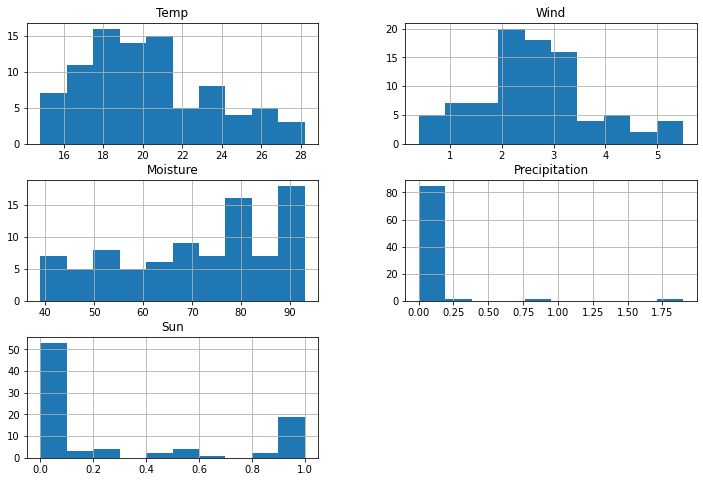

In [16]:
# histogram 그리기
train_x.hist(figsize = (12,8))
plt.show()

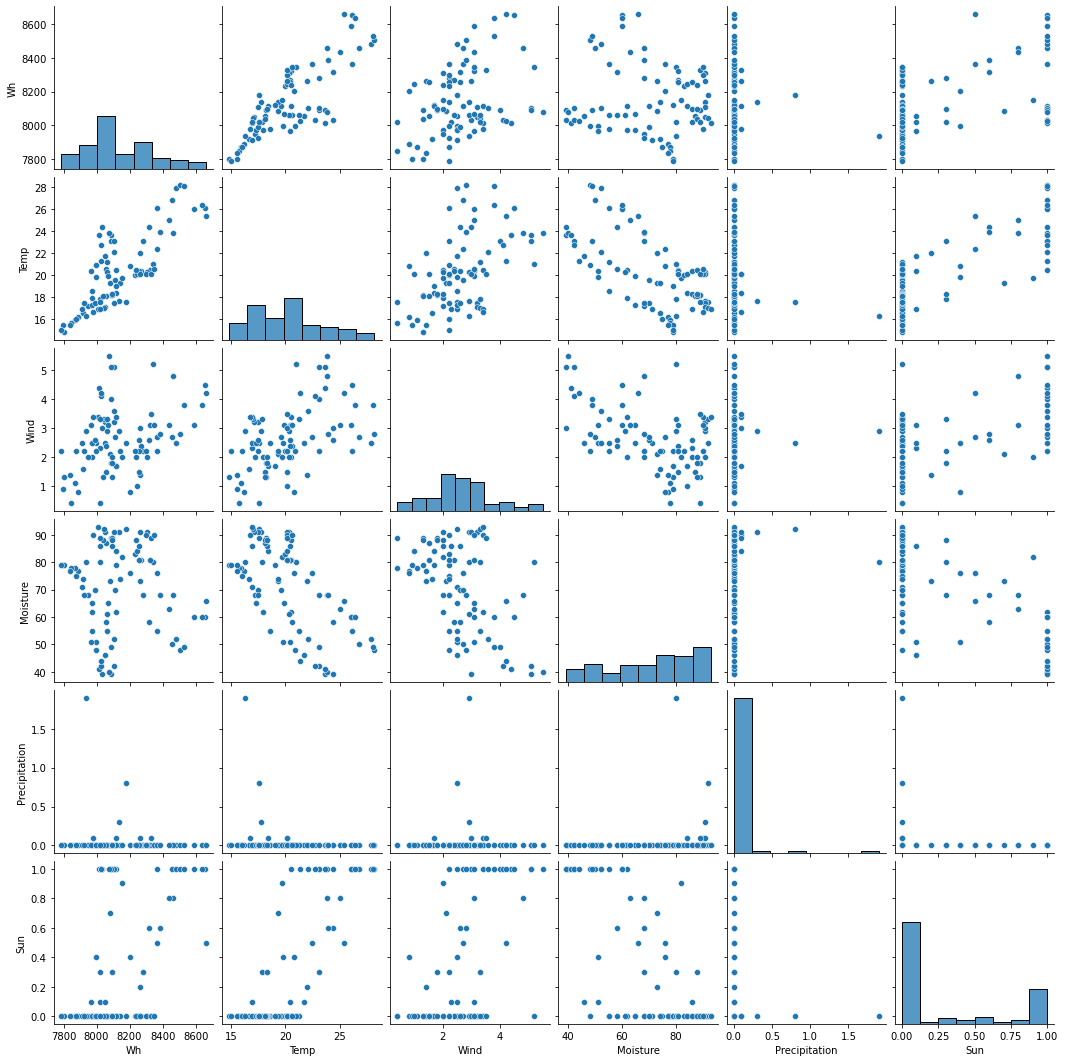

In [17]:
# 변수 간 상관관계가 높게 나오면 변수간의 다중공선성이 발생해서 좋은 모델이 만들어지지 않음
# 상관관계를 시각적으로 확인해보기 위해 변수간 산점도를 그려봄
sns.pairplot(data=pd.concat([pd.DataFrame(train_y),train_x], axis=1))
plt.show()


In [18]:
train_x = train_x['Temp']

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 산점도를 그렸을 때 가장 관계가 뚜렷해보여서

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다! (이것저것 시도해보기 +> 효과 알아보기)

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [19]:
# 사용할 패키지를 import!
from sklearn.preprocessing import MinMaxScaler

In [20]:
# 2D 형태가 되도록 함
train_x = pd.DataFrame(train_x)

In [21]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)

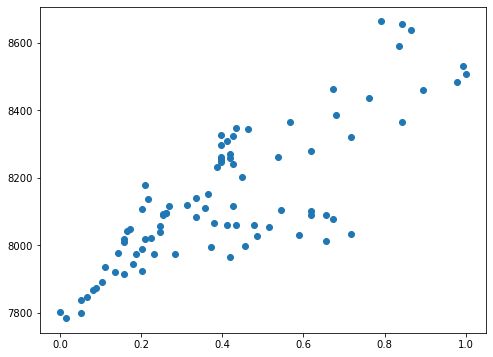

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(train_x, train_y)
plt.show()

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [23]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression

In [24]:
# 선형회귀 모델 생성 후 fitting 시킵니다.

model = LinearRegression().fit(train_x, train_y)

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [25]:
esti_y = model.predict(train_x)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [26]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [27]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 14543.75828


In [28]:
# 모델이 잘되고 있는지 아닌지 직접보고 확인하도록
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

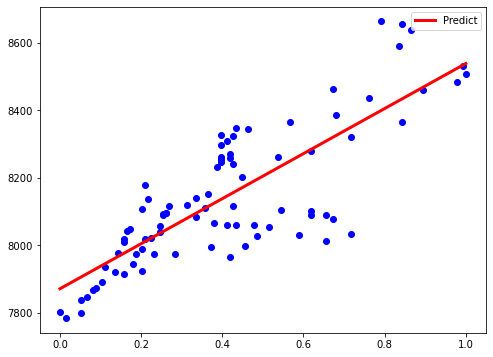

In [29]:
# visualization 하실 분은 진행해주세요!
visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [30]:
# transform을 하시는 분들은 실행해주세요
test_x = test_x['Temp']
test_x = pd.DataFrame(test_x)
test_x = scaler.transform(test_x)

In [31]:
# y1_hat에 predict값 할당
pred_y = model.predict(test_x)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [32]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [33]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 198060.52184


In [34]:
score(train_mse,test_mse)

 13.6182


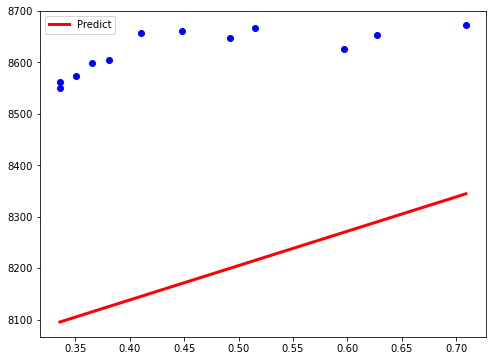

In [35]:
# visualization 하실 분은 진행해주세요!
visualize(model, test_x, test_y)

모델이 매우 예측하지 못함 => 개선이 필요해보인다. (변수 추가 필요)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!